In [1]:
import math
import random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# seed value for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
def read_audio(x):
    y = librosa.load(x)[0]
    return librosa.util.fix_length(y, size=11025)

In [3]:
def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)
    

In [4]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0]

In [5]:
clinical_data = pd.read_csv("Clinical_Meta.csv")
metadata_solicited = pd.read_csv("Solicited_Meta.csv")
metadata_solicited

,participant,filename,sound_prediction_score
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039
...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813


In [6]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = 'solicited/' + metadata_solicited['filename']

# add all other colums from clinical data to metadata 
for col in clinical_data.columns:
    if col not in metadata_solicited.columns:
        metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())

# print columns
print(metadata_solicited.columns)

/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_62916/3789096686.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_62916/3789096686.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())
/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_62916/3789096686.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` i

Index(['participant', 'filename', 'sound_prediction_score', 'label',
       'relative_path', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status'],
      dtype='object')


In [7]:
metadata_solicited['sex'] = metadata_solicited['sex'].map({'Male': 0, 'Female': 1})
metadata_solicited['tb_prior'] = metadata_solicited['tb_prior'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Pul'] = metadata_solicited['tb_prior_Pul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Extrapul'] = metadata_solicited['tb_prior_Extrapul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Unknown'] = metadata_solicited['tb_prior_Unknown'].map({'No': 0, 'Yes': 1})
metadata_solicited['hemoptysis'] = metadata_solicited['hemoptysis'].map({'No': 0, 'Yes': 1})
metadata_solicited['weight_loss'] = metadata_solicited['weight_loss'].map({'No': 0, 'Yes': 1})
metadata_solicited['smoke_lweek'] = metadata_solicited['smoke_lweek'].map({'No': 0, 'Yes': 1})
metadata_solicited['fever'] = metadata_solicited['fever'].map({'No': 0, 'Yes': 1})
metadata_solicited['night_sweats'] = metadata_solicited['night_sweats'].map({'No': 0, 'Yes': 1})

# count number of NaN values
print(metadata_solicited.isnull().sum())


participant                0
filename                   0
sound_prediction_score     0
label                      0
relative_path              0
sex                        0
age                        0
height                    23
weight                     0
reported_cough_dur         0
tb_prior                  23
tb_prior_Pul               0
tb_prior_Extrapul          0
tb_prior_Unknown           0
hemoptysis                 0
heart_rate                 0
temperature                0
weight_loss                0
smoke_lweek                0
fever                      0
night_sweats               0
tb_status                  0
dtype: int64


In [8]:
# drop NaN values
metadata_solicited = metadata_solicited.dropna()

metadata_solicited.head(40)


,participant,filename,sound_prediction_score,label,relative_path,sex,age,height,weight,reported_cough_dur,...,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,solicited/1645088710003-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,solicited/1645088760390-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,solicited/1645088760830-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,solicited/1645088710843-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,solicited/1645088759950-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
5,CODA_TB_0001,1645088758630-recording-1.wav,0.990004,0,solicited/1645088758630-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
6,CODA_TB_0001,1645088758230-recording-1.wav,0.975063,0,solicited/1645088758230-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
7,CODA_TB_0001,1645088738844-recording-1.wav,0.990068,0,solicited/1645088738844-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
8,CODA_TB_0001,1645088784942-recording-1.wav,0.990291,0,solicited/1645088784942-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
9,CODA_TB_0001,1645088784542-recording-1.wav,0.990288,0,solicited/1645088784542-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique participant IDs and their counts
participants_counts = metadata_solicited['participant'].value_counts()

# Initialize empty DataFrames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# Determine the number of participants for each split (adjust ratio as needed)
train_participants, test_participants = train_test_split(participants_counts.index, test_size=0.2, random_state=42)


# Filter data based on the selected participants
df_train = metadata_solicited[metadata_solicited['participant'].isin(train_participants)]
df_test = metadata_solicited[metadata_solicited['participant'].isin(test_participants)]

# Double-check to ensure participants are only in one split
assert set(df_train['participant'].unique()) & set(df_test['participant'].unique()) == set()


In [10]:
# check which split participant a certian patient is in
participant_id = 'CODA_TB_0005'

if df_train['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the train set')
if df_test['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the test set')


CODA_TB_0005 is in the test set


In [11]:
df_train['tb_status'].value_counts()

tb_status
0    5412
1    2336
Name: count, dtype: int64

In [12]:
list_audio_train = []
for i in df_train['relative_path']:
    list_audio_train.append(read_audio(i))

list_audio_test = []
for i in df_test['relative_path']:
    list_audio_test.append(read_audio(i))

mel_spectrogram_train = np.array(list(map(calc_mel_spectrogram, list_audio_train)))
mel_spectrogram_test = np.array(list(map(calc_mel_spectrogram, list_audio_test)))

In [13]:
# Mel spectrogram data
X_mel_train = np.expand_dims(mel_spectrogram_train, -1)
X_mel_test = np.expand_dims(mel_spectrogram_test, -1)

# Tabular data
X_tabular_train = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status','fever',  
                                 'heart_rate', 'temperature', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
                                 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
                                 'weight_loss', 'smoke_lweek', 'night_sweats'], axis=1).values  

X_tabular_test  = df_test.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status','fever',  
                                 'heart_rate', 'temperature', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
                                 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
                                 'weight_loss', 'smoke_lweek', 'night_sweats'], axis=1).values

# Labels
y_train = df_train['label']
y_test = df_test['label']


In [14]:
print(df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status','fever',  
                                 'heart_rate', 'temperature', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
                                 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
                                 'weight_loss', 'smoke_lweek', 'night_sweats'], axis=1).columns)

Index(['sex', 'age'], dtype='object')


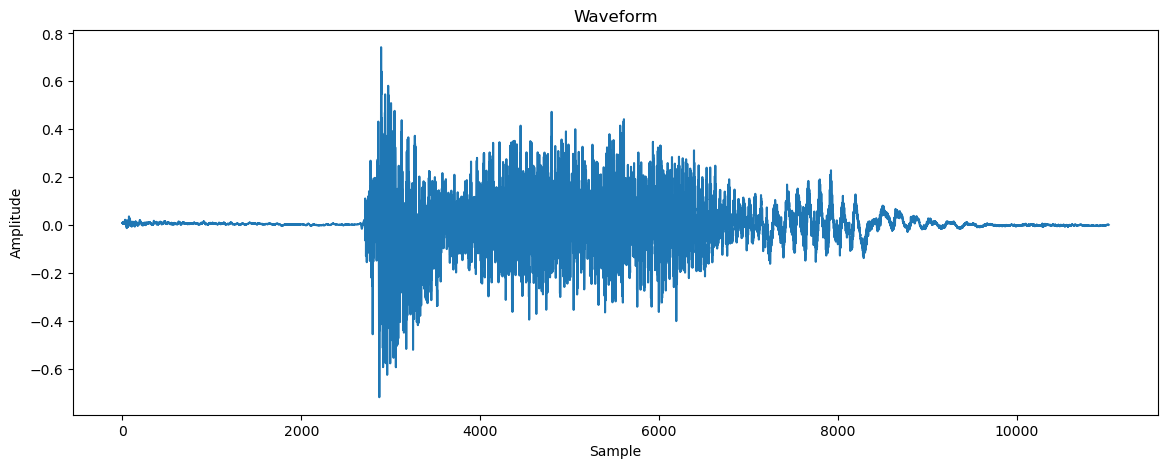

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(list_audio_train[8])
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

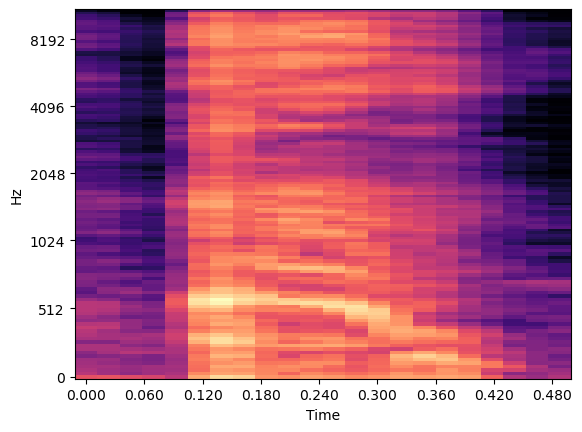

In [16]:
librosa.display.specshow(mel_spectrogram_train[8], y_axis='mel', x_axis='time', auto_aspect=True)

In [17]:
# input shapes
mel_input_shape = X_mel_train.shape[1:]  
tabular_input_shape = X_tabular_train.shape[1]

In [18]:
from tensorflow.keras import layers, models

# Gated Activation Unit (GAU)
def gated_activation_unit(x):
    tanh_out = layers.Activation('tanh')(x)
    sigmoid_out = layers.Activation('sigmoid')(x)
    return layers.Multiply()([tanh_out, sigmoid_out])

# Multi-Head Self-Attention
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, heads, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0

        self.depth = self.d_model // self.heads

        self.query_dense = layers.Dense(self.d_model)
        self.key_dense = layers.Dense(self.d_model)
        self.value_dense = layers.Dense(self.d_model)

        self.combine_heads = layers.Dense(self.d_model)

    def call(self, inputs, **kwargs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split the heads
        query = layers.Reshape((self.heads, self.depth))(query)
        key = layers.Reshape((self.heads, self.depth))(key)
        value = layers.Reshape((self.heads, self.depth))(value)

        # Apply scaled dot-product attention
        attention = layers.Attention()([query, key, value])
        attention = layers.Reshape((self.d_model,))(attention)

        # Combine heads
        output = self.combine_heads(attention)
        return output

# Model architecture
mel_input = layers.Input(shape=mel_input_shape, name='mel_input')
x = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(mel_input)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = gated_activation_unit(x)

# Tabular input
tabular_input = layers.Input(shape=(tabular_input_shape,), name='tabular_input')
y = layers.Dense(1024)(tabular_input)
y = layers.Dense(256)(tabular_input)
y = layers.Dropout(0.15)(y)

# Multi-Head Self-Attention
attention = MultiHeadSelfAttention(heads=8)(x)
weighted_x = layers.Multiply()([x, attention])

# Concatenate the paths
combined = layers.Concatenate()([weighted_x, y])

# Dense layers for final classification
z = layers.Dense(512, activation='leaky_relu')(combined)
z = layers.LayerNormalization()(z)
z = layers.Dense(256, activation='leaky_relu')(z)
z = layers.Dropout(0.15)(z)
output = layers.Dense(1, activation='sigmoid', name='output')(z)

# Create the model
model = models.Model(inputs={'mel_input': mel_input, 'tabular_input': tabular_input}, outputs=output)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel_input (InputLayer)         [(None, 128, 22, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 22, 64)  640         ['mel_input[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 128, 22, 64)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [21]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(y_true, y_pred, alpha=0.70, gamma=2):
    # Calculate the focal loss
    ce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    fl_loss = alpha * tf.pow(1 - pt, gamma) * ce_loss
    return fl_loss

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def s_plus_s(y_true, y_pred):
    return sensitivity(y_true, y_pred) + specificity(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss,
    metrics=['accuracy', 'AUC']
)


In [22]:
EPOCHS = 10

try:
    history = model.fit(
        {'mel_input': X_mel_train, 'tabular_input': X_tabular_train}, y_train,
        epochs=EPOCHS,
        validation_data=({'mel_input': X_mel_test, 'tabular_input': X_tabular_test}, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, restore_best_weights=True),
        ]
    )
except KeyboardInterrupt:
    print("Training interrupted manually.")


Epoch 1/10
243/243 [==============================] - 22s 89ms/step - loss: 0.1000 - accuracy: 0.6879 - auc: 0.5261 - val_loss: 0.0883 - val_accuracy: 0.7098 - val_auc: 0.7182
Epoch 2/10
243/243 [==============================] - 21s 86ms/step - loss: 0.0906 - accuracy: 0.6958 - auc: 0.5721 - val_loss: 0.0966 - val_accuracy: 0.7098 - val_auc: 0.7250
Epoch 3/10
243/243 [==============================] - 22s 91ms/step - loss: 0.0902 - accuracy: 0.6963 - auc: 0.5783 - val_loss: 0.0982 - val_accuracy: 0.7098 - val_auc: 0.7061
Epoch 4/10
243/243 [==============================] - 22s 89ms/step - loss: 0.0877 - accuracy: 0.6946 - auc: 0.6066 - val_loss: 0.0890 - val_accuracy: 0.7341 - val_auc: 0.7232
Epoch 5/10
243/243 [==============================] - 21s 86ms/step - loss: 0.0849 - accuracy: 0.6998 - auc: 0.6344 - val_loss: 0.0848 - val_accuracy: 0.7351 - val_auc: 0.7199
Epoch 6/10
243/243 [==============================] - 22s 90ms/step - loss: 0.0856 - accuracy: 0.6953 - auc: 0.6291 - va

In [ ]:
# #load model
# model = tf.keras.models.load_model('full-model-87.8-model.h5', custom_objects={'MultiHeadSelfAttention':MultiHeadSelfAttention,'focal_loss': focal_loss, 'sensitivity': sensitivity, 'specificity': specificity, 's_plus_s': s_plus_s})

In [23]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_test, 'tabular_input': X_tabular_test})
roc_auc = roc_auc_score(y_test, y_pred)

# add probability to df_test using .loc
df_test.loc[:, 'probability'] = y_pred

# save df_test to csv
df_test.to_csv('solicited-audio-test.csv', index=False)

roc_auc

62/62 [==============================] - 2s 29ms/step


/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_62916/3781593487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'probability'] = y_pred


0.7123934105641423

Max Metrics:
AUC: 0.7637174211248285


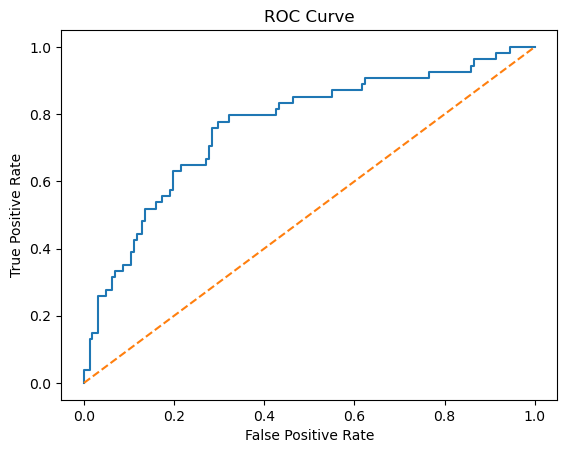

Threshold value is: 0.42263454
Sensitivity: 0.7777777777777778
Specificity: 0.7037037037037037


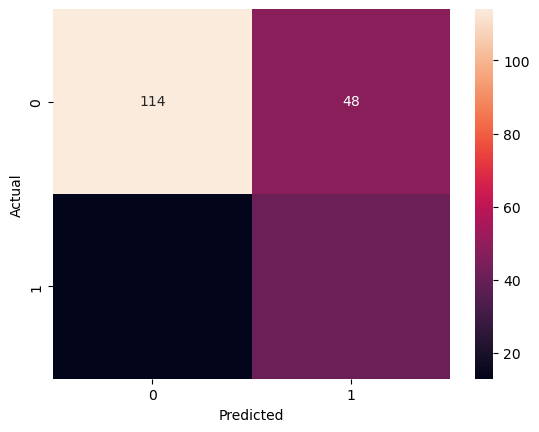

              precision    recall  f1-score   support

       No TB       0.90      0.70      0.79       162
          TB       0.46      0.76      0.57        54

    accuracy                           0.72       216
   macro avg       0.68      0.73      0.68       216
weighted avg       0.79      0.72      0.74       216

Specificity at 70% sensitivity: [0.72222222]
Median Metrics:
AUC: 0.7456561499771376


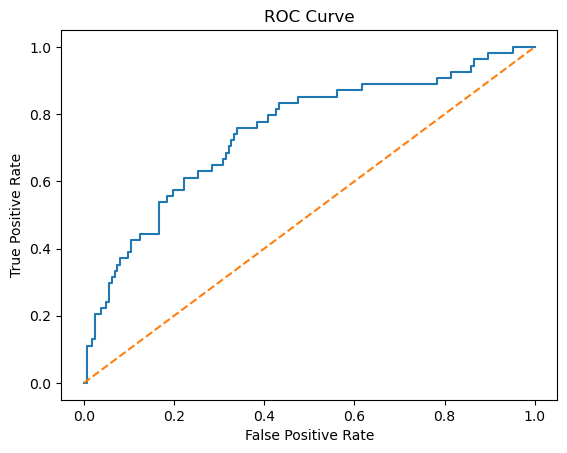

Threshold value is: 0.36589944
Sensitivity: 0.7592592592592593
Specificity: 0.6604938271604939


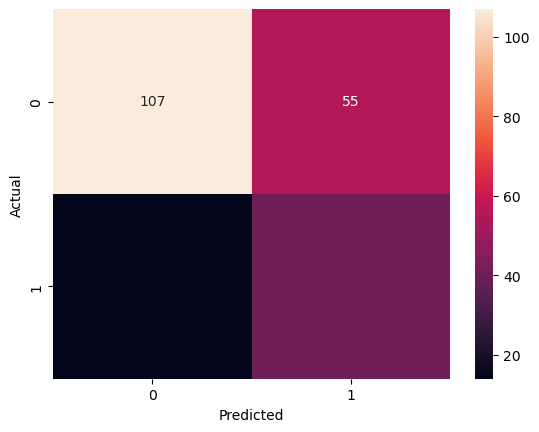

              precision    recall  f1-score   support

       No TB       0.88      0.66      0.76       162
          TB       0.42      0.74      0.54        54

    accuracy                           0.68       216
   macro avg       0.65      0.70      0.65       216
weighted avg       0.77      0.68      0.70       216

Specificity at 70% sensitivity: [0.67901235]
Mean Metrics:
AUC: 0.7409693644261545


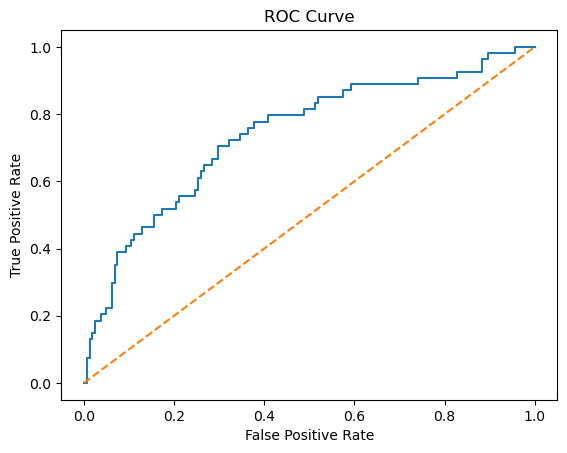

Threshold value is: 0.3779557
Sensitivity: 0.7037037037037037
Specificity: 0.7037037037037037


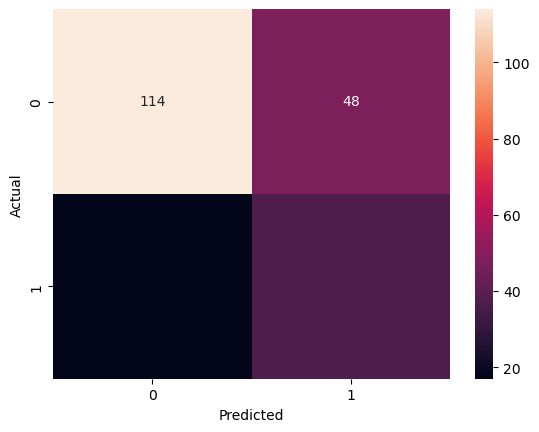

              precision    recall  f1-score   support

       No TB       0.87      0.70      0.78       162
          TB       0.44      0.69      0.53        54

    accuracy                           0.70       216
   macro avg       0.65      0.69      0.66       216
weighted avg       0.76      0.70      0.72       216

Specificity at 70% sensitivity: [0.7037037]
Min Metrics:
AUC: 0.686671239140375


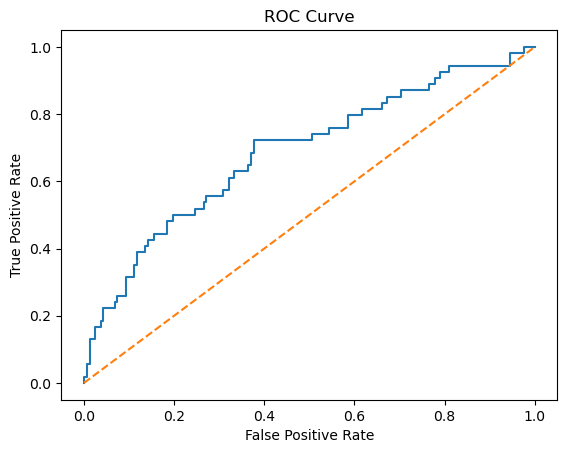

Threshold value is: 0.2904804
Sensitivity: 0.7222222222222222
Specificity: 0.6234567901234568


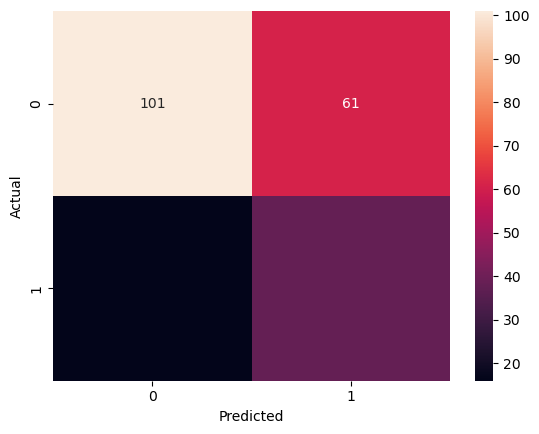

              precision    recall  f1-score   support

       No TB       0.86      0.62      0.72       162
          TB       0.38      0.70      0.50        54

    accuracy                           0.64       216
   macro avg       0.62      0.66      0.61       216
weighted avg       0.74      0.64      0.67       216

Specificity at 70% sensitivity: [0.62345679]
25th Percentile Metrics:
AUC: 0.7168495656149977


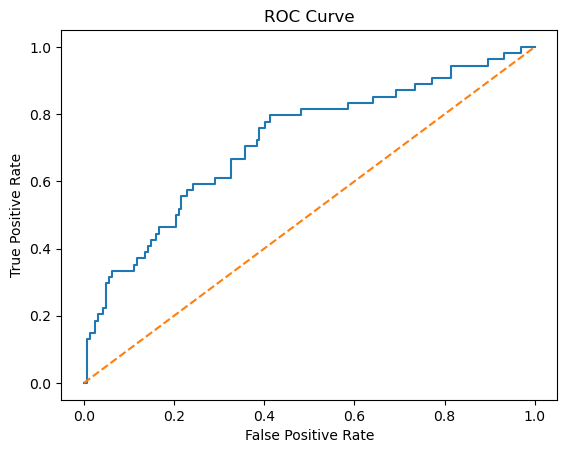

Threshold value is: 0.3121011555194855
Sensitivity: 0.7962962962962963
Specificity: 0.5864197530864197


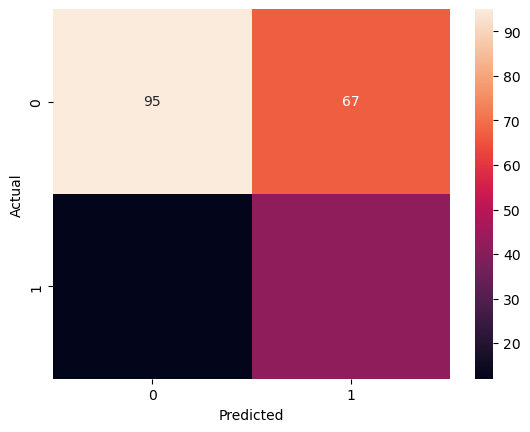

              precision    recall  f1-score   support

       No TB       0.89      0.59      0.71       162
          TB       0.39      0.78      0.52        54

    accuracy                           0.63       216
   macro avg       0.64      0.68      0.61       216
weighted avg       0.76      0.63      0.66       216

Specificity at 70% sensitivity: [0.64197531]
65th Percentile Metrics:
AUC: 0.757087334247828


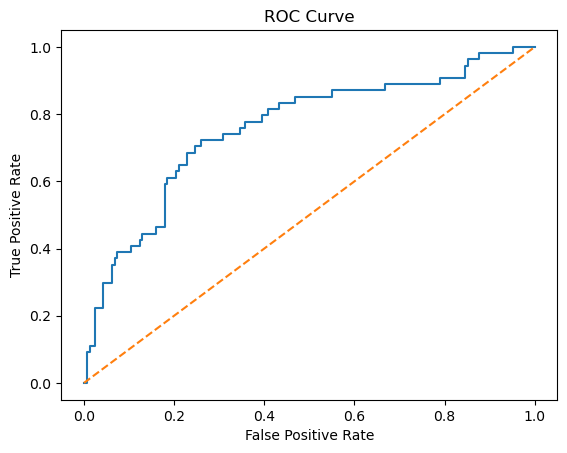

Threshold value is: 0.403628534078598
Sensitivity: 0.7222222222222222
Specificity: 0.7407407407407407


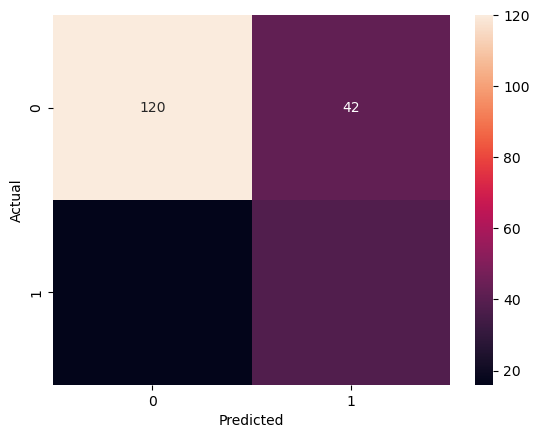

              precision    recall  f1-score   support

       No TB       0.88      0.74      0.81       162
          TB       0.47      0.70      0.57        54

    accuracy                           0.73       216
   macro avg       0.68      0.72      0.69       216
weighted avg       0.78      0.73      0.75       216

Specificity at 70% sensitivity: [0.75308642]


In [24]:
def calculate_metrics():
    roc_auc_score(df['label'], df['probability'])

    # print auc  and auc curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(df['label'], df['probability'])
    print("AUC:", roc_auc_score(df['label'], df['probability']))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    print("Sensitivity:", tpr[optimal_idx])
    print("Specificity:", 1 - fpr[optimal_idx])

    # print the optimal confusion matrix using seaborn
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['label'], y_pred_2)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # print classification report
    from sklearn.metrics import classification_report
    target_names = ['No TB', 'TB']
    print(classification_report(df['label'], y_pred_2, target_names=target_names))

    # get the specificity when the sensitivity is 0.7
    sensitivity = 0.7
    idx = np.argwhere(np.diff(np.sign(tpr - sensitivity))).flatten()
    specificity = 1 - fpr[idx]
    print("Specificity at 70% sensitivity:", specificity)


df_test.loc[:, 'probability'] = y_pred

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.25)
df.to_csv('25th-Percentile-Predictions.csv', index=False)
print("25th Percentile Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.65)
df.to_csv('65th-Percentile-Predictions.csv', index=False)
print("65th Percentile Metrics:")
calculate_metrics()



In [ ]:
# import os
# import pandas as pd

# directory = '/Users/sudac/Downloads/UofA/COVID_cleaned_data 2/data'
# data = []

# for filename in os.listdir(directory):
#     if filename.endswith(".wav"):
#         file_path = os.path.join(directory, filename)

#         label_str = filename.split("_")[1]

#         label = 1 if label_str.lower() == "positive" else 0

#         age_str = filename.split("_")[3].split(".")[0]
#         age = int(age_str[:2])

#         gender_str = filename.split("_")[2]
#         gender = 1 if gender_str.lower() == "female" else 0

#         row = {'File Path': file_path, 'Gender': gender, 'Label': label, 'Age': age}
        
#         data.append(row)

# df = pd.DataFrame(data)
# print(df)


In [ ]:
# list_audio_covid = []
# for i in df['File Path']:
#     list_audio_covid.append(read_audio(i))
#     print(i)

# mel_spectrogram_covid = np.array(list(map(calc_mel_spectrogram, list_audio_covid)))

In [ ]:
# # Mel spectrogram data
# X_mel_covid = np.expand_dims(mel_spectrogram_covid, -1)

# # Tabular data
# X_tabular_covid = df.drop(['Label', 'File Path'], axis=1).values  

# # Labels
# y_covid = df['Label']


In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Get the feature names
feature_names = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1).columns
print(feature_names)

def wrapper_predict(X):
    return model.predict([X_mel_train, X])

def keras_accuracy(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, np.round(y_pred))

class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return wrapper_predict(X)

# Create a wrapped model
wrapped_model = KerasWrapper(model)

# Use the wrapped model with permutation_importance
result = permutation_importance(wrapped_model, X_tabular_train, y_train, scoring=keras_accuracy, n_repeats=2, random_state=42, n_jobs=1)

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

# Plot the permutation importances
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(feature_names)[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()



Index(['sex', 'age', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
       'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
       'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek', 'fever',
       'night_sweats'],
      dtype='object')
 98/243 [===========>..................] - ETA: 4s

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import librosa
from tensorflow.keras.models import load_model

model = joblib.load('Jan-25-model.joblib')

def predict_single_audio(audio_file, demographic_data):
    # read audio file
    audio = read_audio(audio_file)
    mel_spectrogram = calc_mel_spectrogram(audio)
    mel_spectrogram = np.expand_dims(mel_spectrogram, -1)
    print(mel_spectrogram)

    # demographic data
    demographic_data = [0 if x == 'Male' else 1 if x == 'Female' else x for x in demographic_data]
    demographic_data = [0 if x == 'No' else 1 if x == 'Yes' else x for x in demographic_data]
    demographic_data = [float(x) for x in demographic_data]
    demographic_data = np.array(demographic_data)  
    print(demographic_data)
    
    # predict
    prediction = model.predict({'mel_input': np.array([mel_spectrogram]), 'tabular_input': np.array([demographic_data])})
    print('Prediction:', prediction)
    
demographic_data = ['Male', 30, 170, 70, 7, 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 80, 37, 'Yes', 'Yes', 'Yes', 'Yes']
audio_file = 'solicited/1645088710003-recording-1.wav'

predict_single_audio(audio_file, demographic_data)

NameError: name 'joblib' is not defined

In [ ]:
# test with shap for feature importance
